Data Collection & HTML Parsing (15%)

In [26]:
#grab the libraries we need
import pandas as pd
from bs4 import BeautifulSoup
import re

#load our dataset
df = pd.read_csv('../data/data.csv')

#get rid of rows with missing html
df = df.dropna(subset=['html_content'])
print(f"Loaded {len(df)} rows with HTML content.")

def parse_html(html_content):
    """grabs title and text from html"""
    try:
        soup = BeautifulSoup(html_content, 'html.parser')
        
        #grab the title
        title = soup.title.string if soup.title else 'No Title Found'
        
        #find main content
        main_content = soup.find('main') or soup.find('article')
        if not main_content:
            main_content = soup.find('body')

        if not main_content:
            return title, "No Body Content Found", 0

        #clean up the junk
        for tag in main_content(['script', 'style', 'nav', 'footer', 'header']):
            tag.decompose()
            
        #get clean text
        body_text = main_content.get_text(separator=' ')
        body_text = re.sub(r'\s+', ' ', body_text).strip()
        
        word_count = len(body_text.split())
        return title, body_text, word_count
    
    except Exception as e:
        print(f"Error parsing HTML: {e}")
        return "Parsing Error", "Parsing Error", 0

#store results here
parsed_data = []

#process each webpage
for index, row in df.iterrows():
    title, body_text, word_count = parse_html(row['html_content'])
    parsed_data.append({
        'url': row['url'],
        'title': title,
        'body_text': body_text,
        'word_count': word_count
    })

#save everything
df_extracted = pd.DataFrame(parsed_data)
output_path = '../data/extracted_content.csv'
df_extracted.to_csv(output_path, index=False)

print(f"\nSaved extracted content to {output_path}")
df_extracted.head()

Loaded 69 rows with HTML content.

Saved extracted content to ../data/extracted_content.csv

Saved extracted content to ../data/extracted_content.csv


,url,title,body_text,word_count
0,https://www.cm-alliance.com/cybersecurity-blog,Cyber Security Blog,Cybersecurity Blog Cybersecurity Measures Ever...,2017
1,https://www.varonis.com/blog/cybersecurity-tips,Top 10 Cybersecurity Awareness Tips: How to St...,Blog Privacy & Compliance Top 10 Cybersecurity...,1747
2,https://www.cisecurity.org/insights/blog/11-cy...,11 Cyber Defense Tips to Stay Secure at Work a...,Home Insights Blog Posts 11 Cyber Defense Tips...,1058
3,https://www.cisa.gov/topics/cybersecurity-best...,Cybersecurity Best Practices | Cybersecurity a...,Cybersecurity Best Practices CISA provides inf...,826
4,https://nordlayer.com/learn/network-security/b...,Network Security 101: Understanding the Basics,Home Learning center Network security Network ...,2188


Text Preprocessing & Feature Engineering (25%)

In [27]:
#text analysis stuff
import nltk
from nltk.tokenize import sent_tokenize
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

#need this for sentence splitting
nltk.download('punkt')

#grab our processed content
df_features = pd.read_csv('../data/extracted_content.csv')

#count sentences
df_features['sentence_count'] = df_features['body_text'].apply(lambda x: len(sent_tokenize(str(x))))

#check readability score
df_features['flesch_reading_ease'] = df_features['body_text'].apply(lambda x: textstat.flesch_reading_ease(str(x)))

#setup for finding keywords
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

#make sure text isn't empty
df_features['body_text'] = df_features['body_text'].fillna('')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_features['body_text'])

#get keywords
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

def get_top_keywords(doc_vector, n=5):
    """finds important words in text"""
    top_indices = doc_vector.argsort()[-n:][::-1]
    return "|".join(feature_names[top_indices])

#grab top keywords
top_keywords_list = [get_top_keywords(doc_vec) for doc_vec in tfidf_matrix.toarray()]
df_features['top_keywords'] = top_keywords_list

#save vectors for comparing later
df_features['embedding'] = [str(list(vec)) for vec in tfidf_matrix.toarray()]

#save to file
features_path = '../data/features.csv'
df_features.to_csv(features_path, index=False)

print(f"\nSaved features to {features_path}")
df_features.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rje24\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Saved features to ../data/features.csv


,url,title,body_text,word_count,sentence_count,flesch_reading_ease,top_keywords,embedding
0,https://www.cm-alliance.com/cybersecurity-blog,Cyber Security Blog,Cybersecurity Blog Cybersecurity Measures Ever...,2017,60,41.600994,2025|cyber|september|october|attacks,"[0.0, 0.0, 0.03501414081940905, 0.0, 0.0285887..."
1,https://www.varonis.com/blog/cybersecurity-tips,Top 10 Cybersecurity Awareness Tips: How to St...,Blog Privacy & Compliance Top 10 Cybersecurity...,1747,94,40.871699,access|security|data|cybersecurity|app,"[0.0, 0.023107774456185868, 0.0358170839622718..."
2,https://www.cisecurity.org/insights/blog/11-cy...,11 Cyber Defense Tips to Stay Secure at Work a...,Home Insights Blog Posts 11 Cyber Defense Tips...,1058,73,53.262918,authentication|don|cyber|secure|protect,"[0.0, 0.0, 0.025433977349204363, 0.0, 0.110755..."
3,https://www.cisa.gov/topics/cybersecurity-best...,Cybersecurity Best Practices | Cybersecurity a...,Cybersecurity Best Practices CISA provides inf...,826,27,-2.538002,cybersecurity|cyber|practices|organizations|best,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.03713462319736602,..."
4,https://nordlayer.com/learn/network-security/b...,Network Security 101: Understanding the Basics,Home Learning center Network security Network ...,2188,181,25.769415,network|security|monitoring|devices|access,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Duplicate & Thin Content Detection (20%)

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import json

#load features
df_analysis = pd.read_csv('../data/features.csv')

#flag short articles
df_analysis['is_thin'] = df_analysis['word_count'] < 500

#load vectors back
embedding_list = [json.loads(vec_str) for vec_str in df_analysis['embedding']]
tfidf_matrix_loaded = np.array(embedding_list)

#check how similar articles are
cosine_sim_matrix = cosine_similarity(tfidf_matrix_loaded)

#80% similar = probably duplicate
similarity_threshold = 0.80

#find duplicates
duplicate_pairs = []
for i in range(len(cosine_sim_matrix)):
    for j in range(i + 1, len(cosine_sim_matrix)):
        if cosine_sim_matrix[i, j] > similarity_threshold:
            duplicate_pairs.append({
                'url1': df_analysis.iloc[i]['url'],
                'url2': df_analysis.iloc[j]['url'],
                'similarity': cosine_sim_matrix[i, j]
            })

#save what we found
df_duplicates = pd.DataFrame(duplicate_pairs)
duplicates_path = '../data/duplicates.csv'
df_duplicates.to_csv(duplicates_path, index=False)

#quick stats
total_pages = len(df_analysis)
thin_pages = df_analysis['is_thin'].sum()
thin_percentage = (thin_pages / total_pages) * 100

print("--- Content Analysis Summary ---")
print(f"Total pages analyzed: {total_pages}")
print(f"Duplicate pairs found (>{similarity_threshold*100}%): {len(df_duplicates)}")
print(f"Thin content pages (<500 words): {thin_pages} ({thin_percentage:.2f}%)")
print(f"\nDuplicate pairs saved to {duplicates_path}")

df_duplicates.head()

--- Content Analysis Summary ---
Total pages analyzed: 69
Duplicate pairs found (>80.0%): 13
Thin content pages (<500 words): 14 (20.29%)

Duplicate pairs saved to ../data/duplicates.csv


,url1,url2,similarity
0,https://guardiandigital.com/resources/blog/gui...,https://inspiredelearning.com/blog/phishing-pr...,0.862243
1,https://en.wikipedia.org/wiki/SD-WAN,https://www.cisco.com/site/us/en/learn/topics/...,0.874139
2,https://en.wikipedia.org/wiki/SD-WAN,https://www.fortinet.com/resources/cyberglossa...,0.906981
3,https://www.cisco.com/site/us/en/learn/topics/...,https://www.fortinet.com/resources/cyberglossa...,0.901579
4,https://www.microsoft.com/en-us/security/busin...,https://www.zscaler.com/resources/security-ter...,0.900535


Content Quality Scoring (25%)

--- Model Performance ---
Overall Accuracy: 0.9048

              precision    recall  f1-score   support

        High       1.00      0.67      0.80         3
         Low       0.90      1.00      0.95         9
      Medium       0.89      0.89      0.89         9

    accuracy                           0.90        21
   macro avg       0.93      0.85      0.88        21
weighted avg       0.91      0.90      0.90        21


--- Confusion Matrix (Text) ---
[[2 0 1]
 [0 9 0]
 [0 1 8]]

✓ Saved confusion matrix to: ../confusion_matrix.png

--- Most Important Features ---
flesch_reading_ease    0.507641
word_count             0.261638
sentence_count         0.230721
dtype: float64

Saved model to ../models/quality_model.pkl
Saved encoder to ../models/label_encoder.pkl

✓ Saved confusion matrix to: ../confusion_matrix.png

--- Most Important Features ---
flesch_reading_ease    0.507641
word_count             0.261638
sentence_count         0.230721
dtype: float64

Saved model to ../mo

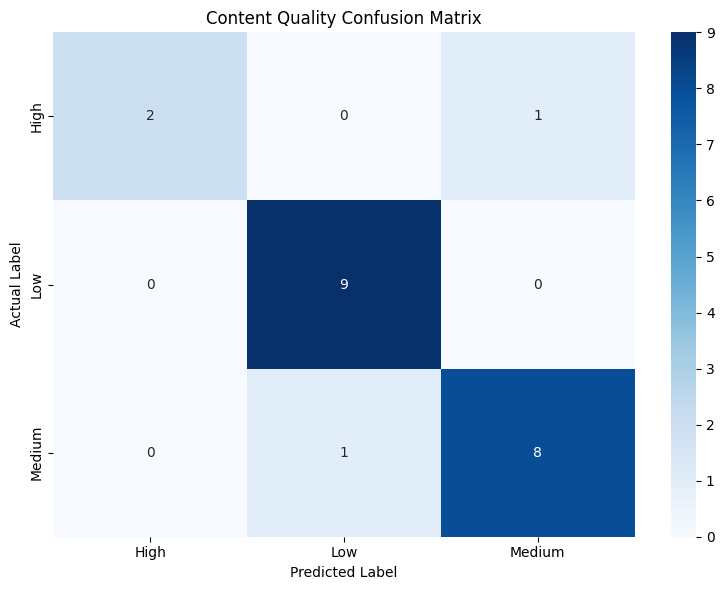

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

#get data ready
df_model = pd.read_csv('../data/features.csv')

#label content quality
def create_label(row):
    if row['word_count'] > 1500 and (50 <= row['flesch_reading_ease'] <= 70):
        return 'High'
    elif row['word_count'] < 500 or row['flesch_reading_ease'] < 30:
        return 'Low'
    else:
        return 'Medium'

df_model['quality_label'] = df_model.apply(create_label, axis=1)

#setup ml stuff
features = ['word_count', 'sentence_count', 'flesch_reading_ease']
X = df_model[features].fillna(0)
y = df_model['quality_label']

#convert labels to numbers
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
label_names = encoder.classes_

#split for training
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.30, random_state=42, stratify=y_encoded)

#train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#check accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("--- Model Performance ---")
print(f"Overall Accuracy: {accuracy:.4f}\n")
print(classification_report(y_test, y_pred, target_names=label_names, zero_division=0))

#confusion matrix text version
print("\n--- Confusion Matrix (Text) ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

#make it pretty
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.title('how well did we classify?')
plt.ylabel('actual')
plt.xlabel('predicted')
plt.tight_layout()

#save the graph
figure_path = '../confusion_matrix.png'
plt.savefig(figure_path)
print(f"\n✓ saved graph to: {figure_path}")

#what matters most?
feature_importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print("\n--- most important stuff ---")
print(feature_importances)

#save for later
model_path = '../models/quality_model.pkl'
encoder_path = '../models/label_encoder.pkl'
joblib.dump(model, model_path)
joblib.dump(encoder, encoder_path)

print(f"\nsaved model: {model_path}")
print(f"saved encoder: {encoder_path}")

Real-Time Analysis Demo (15%)

In [ ]:
import requests
import json
import joblib
import numpy as np

#load stuff we saved
model = joblib.load('../models/quality_model.pkl')
encoder = joblib.load('../models/label_encoder.pkl')

#setup keyword finder
df_features = pd.read_csv('../data/features.csv')
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_vectorizer.fit(df_features['body_text'].fillna(''))

#get comparison data
df_analysis = pd.read_csv('../data/features.csv')
embedding_list = [json.loads(vec_str) for vec_str in df_analysis['embedding']]
full_tfidf_matrix = np.array(embedding_list)
full_url_list = df_analysis['url'].tolist()

def analyze_url(url):
    """checks out a webpage and tells us about it"""
    try:
        #grab the page
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}
        response = requests.get(url, headers=headers, timeout=10)
        
        if response.status_code != 200:
            return {"error": f"cant get the page (status {response.status_code})"}
        
        #get content
        title, body_text, word_count = parse_html(response.content)
        
        if body_text == "Parsing Error":
            return {"error": "cant read the page"}

        #check text stats
        sentence_count = len(sent_tokenize(body_text))
        readability = textstat.flesch_reading_ease(body_text)
        is_thin = word_count < 500
        
        #quality check
        live_features = np.array([[word_count, sentence_count, readability]])
        quality_prediction_encoded = model.predict(live_features)
        quality_label = encoder.inverse_transform(quality_prediction_encoded)[0]
        
        #look for copies
        live_vector = tfidf_vectorizer.transform([body_text])
        similarities = cosine_similarity(live_vector, full_tfidf_matrix)
        
        #find similar stuff
        similar_to = []
        for i, similarity_score in enumerate(similarities[0]):
            if similarity_score > 0.70:
                similar_to.append({
                    "url": full_url_list[i],
                    "similarity": round(similarity_score, 2)
                })
        
        #sort by similarity
        similar_to = sorted(similar_to, key=lambda x: x['similarity'], reverse=True)

        #pack it up
        result = {
            "url": url,
            "word_count": word_count,
            "readability": round(readability, 2),
            "quality_label": quality_label,
            "is_thin": is_thin,
            "similar_to": similar_to[:3]  #top 3 matches
        }
        return result

    except Exception as e:
        return {"error": f"oops: {str(e)}"}

#try it out
test_url = "https://simple.wikipedia.org/wiki/Machine_learning"
result = analyze_url(test_url)
print(json.dumps(result, indent=2))

{
  "url": "https://simple.wikipedia.org/wiki/Machine_learning",
  "word_count": 1596,
  "readability": -3.4,
  "quality_label": "Low",
  "is_thin": false,
  "similar_to": [
    {
      "url": "https://simple.wikipedia.org/wiki/Machine_learning",
      "similarity": 1.0
    },
    {
      "url": "https://en.wikipedia.org/wiki/Machine_learning",
      "similarity": 0.82
    }
  ]
}
